#Mounting & Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

#The Model

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
https://github.com/priya-dwivedi/Deep-Learning/tree/master/resnet_keras

In [ ]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [ ]:
df_train=pd.read_excel("train0-7_NoPED.xlsx")
df_test=pd.read_excel("test0-7_NoPED.xlsx")

In [ ]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,horizontal_flip=True,rotation_range=40)
dir = '/content/drive/My Drive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13936 validated image filenames belonging to 3 classes.


In [ ]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3483 validated image filenames belonging to 3 classes.


In [ ]:
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) )
#model.add(data_augmentation)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(NUM_CLASSES , activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 30,workers=8, callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)], batch_size = BATCH_SIZE)

Epoch 1/30
 33/436 [=>............................] - ETA: 41:27 - loss: 1.6027 - accuracy: 0.5475

KeyboardInterrupt: ignored

In [ ]:
model.save('ResNet1_NoPED.h5')

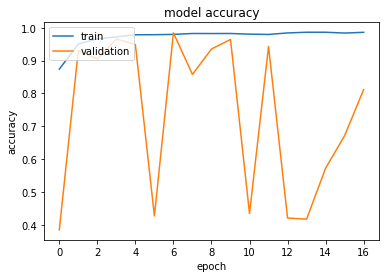

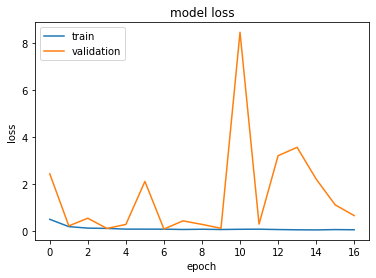

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)#Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4355 validated image filenames belonging to 3 classes.


In [ ]:
#Pruebo con el modelo generado sin usar las pediátricas. También puedo probar con el otro modelo que ya vimos que se comportaba muy bien para imágenes no pediátricas
model = load_model('ResNet1_NoPED.h5')

In [ ]:
model = load_model('ResNet5.h5')

In [ ]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

1602/4355 [==========>...................] - ETA: 2:20:03

UnknownError: ignored

In [ ]:
#Calculamos la matriz de predicciones
#result_test=model.predict(test_batches, verbose=1)
print ("Loss = " + str(result_test[0]))
print ("Test Accuracy = " + str(result_test[1]))

In [ ]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

In [ ]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

In [ ]:
#Obtenemos el nombre de clase asignado a cada clase
preds_classes = [classes_dict[p] for p in preds]

In [ ]:
# A qué clase asigna cada imagen
preds_classes

In [ ]:
#Evaluar cuantas predicciones hay de cada clase
pd.Series(preds_classes).value_counts()

In [ ]:
import numpy as np
#Obtenemos el nombre de clase de la etiqueta verdadera (groun-truths)
gts = np.array([classes_dict[p] for p in test_batches.classes])

In [ ]:
#Evaluamos métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(gts,preds_classes))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize=20)
    plt.xlabel('Predicción del modelo', fontsize=20)
    plt.show()

In [ ]:
confusionMatrix = confusion_matrix(gts,preds_classes)

plot_confusion_matrix(confusionMatrix,test_batches.class_indices.keys())

In [ ]:
Verdaderos resultados = [195,5,16
                         ,0,1432,1,
                         2,4,2701]

In [ ]:
precision_AP = 195/(195+5+16)
print(precision_AP)
recall_AP = 195/(195+2)
print(recall_AP)
F1_AP = 2* (precision_AP*recall_AP)/(precision_AP+recall_AP)
print(F1_AP)

0.9027777777777778
0.9898477157360406
0.9443099273607748


In [ ]:
precision_PA = 2701/(2701+2+4)
print(precision_PA)
recall_PA = 2701/(2701+17)
print(recall_PA)
F1_PA = 2* (precision_PA*recall_PA)/(precision_PA+recall_PA)
print(F1_PA)

0.9977835241965275
0.9937454010301693
0.9957603686635944


In [ ]:
precision_L = 2701/(2701+2+4)
print(precision_L)
recall_L = 2701/(2701+17)
print(recall_L)
F1_L = 2* (precision_L*recall_L)/(precision_L+recall_L)
print(F1_L)

0.9977835241965275
0.9937454010301693
0.9957603686635944


In [ ]:
#Macro F1 
Macro_F1 = (F1_AP+F1_L+F1_PA)/3
Macro_F1

0.9957603686635944

In [ ]:
df_test

,Unnamed: 0,ImageID,ImageDir,Projection
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA
...,...,...,...,...
4355,4355,1/201028909759225999897549410032918111027_-ruc...,1,PA
4356,4356,6/155634289149161267049279102303067537749_ba86...,6,L
4357,4357,2/282333874080047874618440451478871639364_1xiw...,2,PA
4358,4358,5/99711541869715028575308087414656016123_cysyz...,5,L


In [ ]:
df_test["Pred"] = preds_classes

In [ ]:
df_test

,Unnamed: 0,ImageID,ImageDir,Projection,Pred
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA
...,...,...,...,...,...
4355,4355,1/201028909759225999897549410032918111027_-ruc...,1,PA,PA
4356,4356,6/155634289149161267049279102303067537749_ba86...,6,L,L
4357,4357,2/282333874080047874618440451478871639364_1xiw...,2,PA,PA
4358,4358,5/99711541869715028575308087414656016123_cysyz...,5,L,L


In [ ]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]

In [ ]:
df_test.to_csv('Results_Resnet5')

In [ ]:
df_test[df_test["result"]==False]

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
6,6,7/93362714622355113593892142647140052009_eoqzm...,7,AP_horizontal,L,False
76,76,4/51660009030804800622517791419411123073_-6v4c...,4,PA,L,False
94,94,5/26058313305469716031660539225317181435_luhas...,5,PA,L,False
341,341,7/198132506605130985418916659332106275189_2_4p...,7,AP_horizontal,L,False
532,532,0/125208930338141968501244764499259500218_arhz...,0,PA,AP_horizontal,False
559,559,3/322729003998044809439852710028606111975_arku...,3,L,PA,False
605,605,6/322464264958251815080267306691051011848_5nbi...,6,AP_horizontal,PA,False
888,888,0/84180441191851216898438329896662769894_2_3q4...,0,AP_horizontal,PA,False
1020,1020,0/248844832712596910384483822647133359902_ncfu...,0,AP_horizontal,L,False
1021,1021,2/109632595289119302525510049632709306408_plcd...,2,AP_horizontal,PA,False


In [ ]:
df_test_bad=df_test[df_test["result"]==False]

In [ ]:
df_test_bad

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
6,6,7/93362714622355113593892142647140052009_eoqzm...,7,AP_horizontal,L,False
76,76,4/51660009030804800622517791419411123073_-6v4c...,4,PA,L,False
94,94,5/26058313305469716031660539225317181435_luhas...,5,PA,L,False
341,341,7/198132506605130985418916659332106275189_2_4p...,7,AP_horizontal,L,False
532,532,0/125208930338141968501244764499259500218_arhz...,0,PA,AP_horizontal,False
559,559,3/322729003998044809439852710028606111975_arku...,3,L,PA,False
605,605,6/322464264958251815080267306691051011848_5nbi...,6,AP_horizontal,PA,False
888,888,0/84180441191851216898438329896662769894_2_3q4...,0,AP_horizontal,PA,False
1020,1020,0/248844832712596910384483822647133359902_ncfu...,0,AP_horizontal,L,False
1021,1021,2/109632595289119302525510049632709306408_plcd...,2,AP_horizontal,PA,False


#Curva AUC-ROC

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model, , df_test["Pred"])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

NameError: ignored

In [ ]:
type(np.array(preds_classes))

numpy.ndarray

In [ ]:
from tensorflow.keras.metrics import AUC
m = AUC(num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, label_weights=None)
m.update_state(gts, np.array(preds_classes))
m.result().numpy()

UnimplementedError: ignored

#Análisis de predicciones incorrectas

In [ ]:
%cd /content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino


Ground Truth: AP_horizontal
Prediction: L


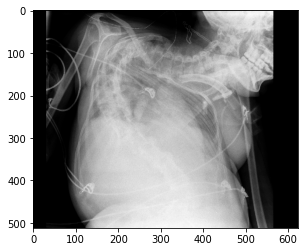

In [ ]:
ROW = 6
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


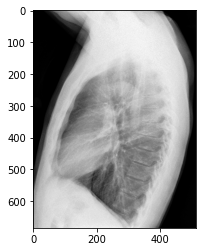

In [ ]:
ROW = 76
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


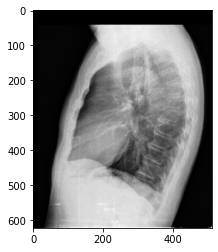

In [ ]:
ROW = 94
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: L


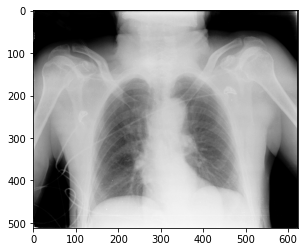

In [ ]:
ROW = 341
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


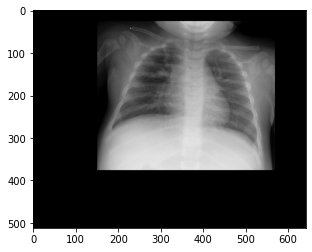

In [ ]:
ROW = 532
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: PA


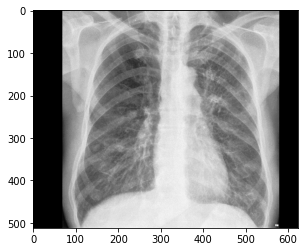

In [ ]:
ROW = 559
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


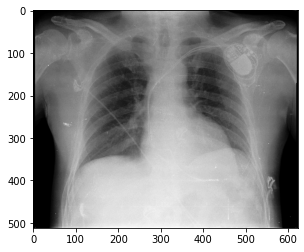

In [ ]:
ROW = 605
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


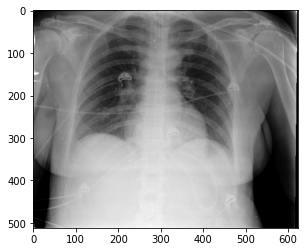

In [ ]:
ROW = 888
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: L


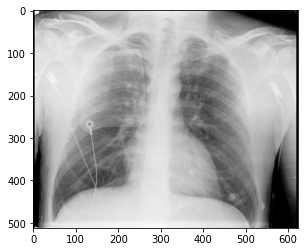

In [ ]:
ROW = 1020
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


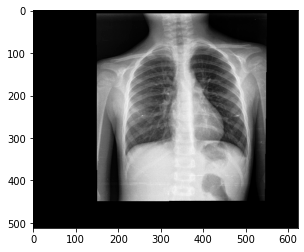

In [ ]:
ROW = 1021
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


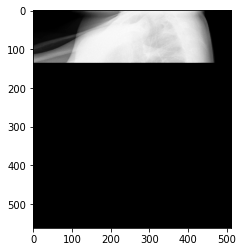

In [ ]:
ROW = 1046
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


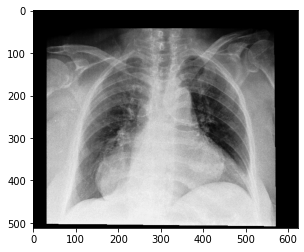

In [ ]:
ROW = 1081
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: PA


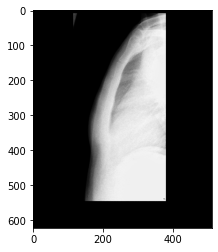

In [ ]:
ROW = 1172
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


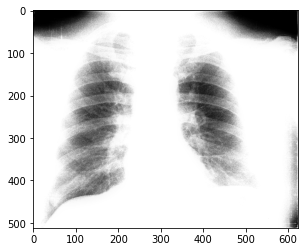

In [ ]:
ROW = 1191
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


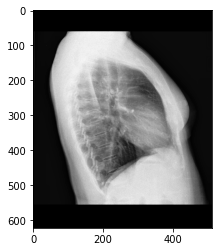

In [ ]:
ROW = 1326
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


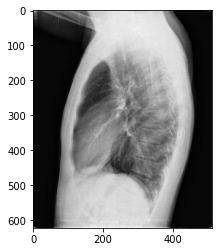

In [ ]:
ROW = 1389
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


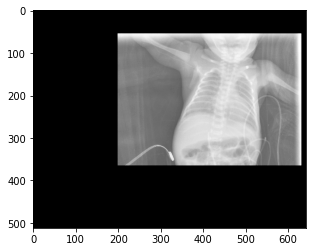

In [ ]:
ROW = 1488
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


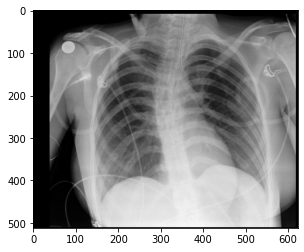

In [ ]:
ROW = 1508
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


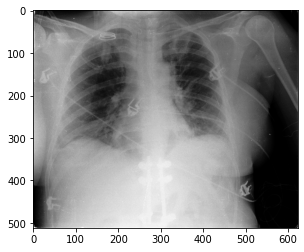

In [ ]:
ROW = 1587
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


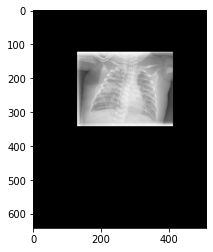

In [ ]:
ROW = 2039
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: L


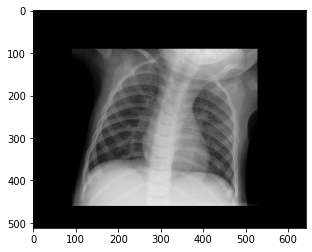

In [ ]:
ROW = 2074
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


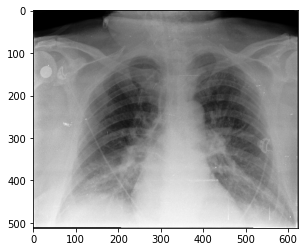

In [ ]:
ROW = 2085
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


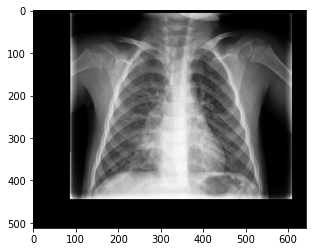

In [ ]:
ROW = 2103
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


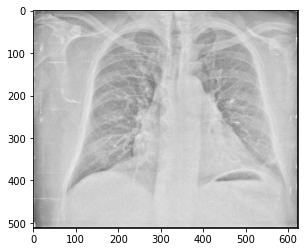

In [ ]:
ROW = 2314
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


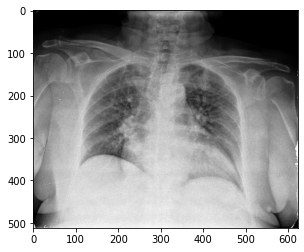

In [ ]:
ROW = 2521
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


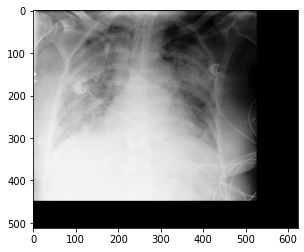

In [ ]:
ROW = 2686
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: L


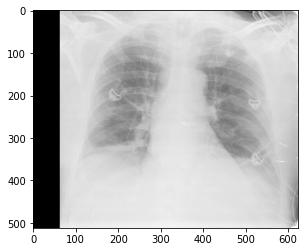

In [ ]:
ROW = 2707
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


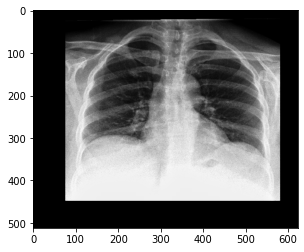

In [ ]:
ROW = 3251
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


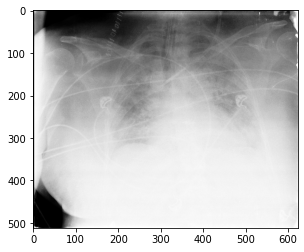

In [ ]:
ROW = 3339
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


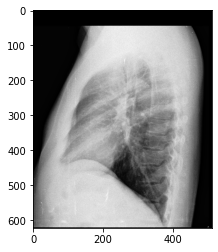

In [ ]:
ROW = 3356
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


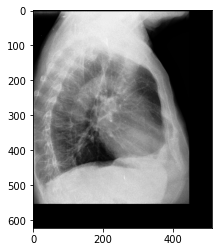

In [ ]:
ROW = 3497
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


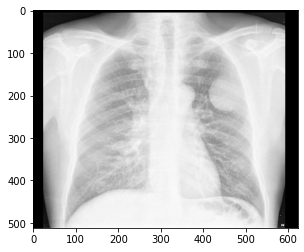

In [ ]:
ROW = 3672
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


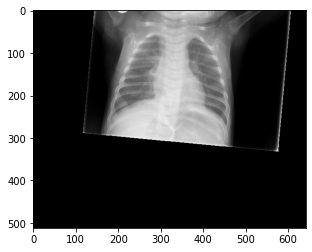

In [ ]:
ROW = 3855
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: L


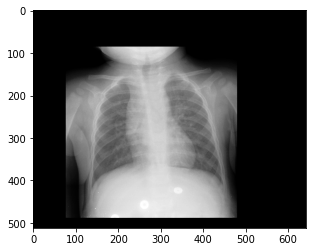

In [ ]:
ROW = 3893
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


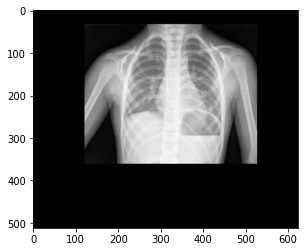

In [ ]:
ROW = 4090
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


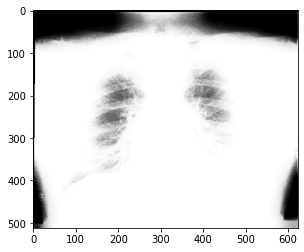

In [ ]:
ROW = 4126
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


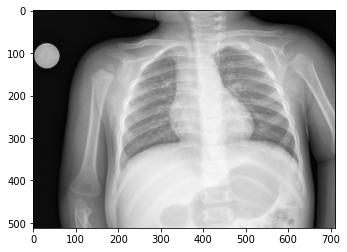

In [ ]:
ROW = 4130
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


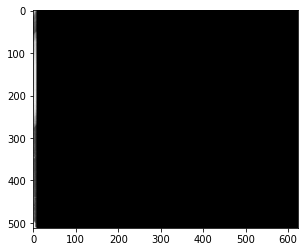

In [ ]:
ROW = 4171
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


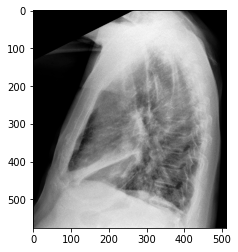

In [ ]:
ROW = 4309
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])